A Python implementation of [Sky Region Detection in a Single Image for Autonomous Ground Robot Navigation (Shen and Wang, 2013)](http://cdn.intechopen.com/pdfs/45787.pdf)

In [0]:
# ipython glue and helpers

import cv2
import numpy as np
from scipy import spatial


def make_mask(b, image):
    mask = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.uint8)
    for xx, yy in enumerate(b):
        mask[yy:, xx] = 255

    return mask


def display_mask(b, image, color=[0, 0, 255]):
    result = image.copy()
    overlay = np.full(image.shape, color, image.dtype)

    display(
        cv2.addWeighted(
            cv2.bitwise_and(overlay, overlay, mask=make_mask(b, image)),
            1,
            image,
            1,
            0,
            result
        )
    )


def display_cv2_image(image):
    return cv2.imencode('.png', image)[1].tostring()


ip = get_ipython()
png_f = ip.display_formatter.formatters['image/png']
png_f.for_type_by_name('numpy', 'ndarray', display_cv2_image);

# 2.0 Algorithm Details 
## 2.1 Image Pre-processing and Gradient Image Calculation

> If the input image is a colour image, we convert it into a greyscale image. 

> From the greyscale image, we calculate its corresponding gradient image with the Sobel operator. As is known, the Sobel operator contains two operators in the horizontal and vertical directions. We convolve the input greyscale image with these two operators and get two gradient images. Finally we calculate the gradient magnitude image by combining the two gradient images.

In [0]:
def color_to_gradient(image):
    gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    return np.hypot(
        cv2.Sobel(gray, cv2.CV_64F, 1, 0),
        cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    )

## 2.2 Preliminary Sky Region Detection
## 2.2.1 Definition of the Energy Function 

> Inspired by the energy function proposed in *Ettinger S, Nechyba M, Ifju P, Waszak M (2002) Vision-Guided Flight Stability and Control for Micro Air Vehicles*: 

### Equation 1
$$
J = \frac{1}{|\Sigma_s| + |\Sigma_g| + (\lambda^s_1 + \lambda^s_2 + \lambda^s_3)^2 + (\lambda^g_1 + \lambda^g_2 + \lambda^g_3)^2}
$$

> where $\Sigma_s$ and $\Sigma_g$ are the covariance matrices of the pixels that are described by RGB values in sky and ground regions, respectively. They are both 3×3 matrices, which are defined as follows: 

### Equation 2
$$
\Sigma_s = \frac{1}{N_s} \sum_{(y,x) \in sky} \big(I^s(y, x) - \mu^s\big)\big(I^s(y, x)-\mu^s\big)^T
$$

### Equation 3
$$
\Sigma_g = \frac{1}{N_g} \sum_{(y,x) \in ground} \big(I^g(y, x) - \mu^g\big)\big(I^g(y, x)-\mu^g\big)^T
$$

> where $Ns$ and $Ng$ are the number of pixels in the sky and ground regions, respectively, while $\mu^s$ and $\mu^g$ are 3×1 column vectors that represent the average RGB values in the sky and ground regions, respectively.

> $\lambda^s_i$ and $\lambda^g_i$ $(i = \{1, 2, 3\})$ are Eigen values corresponding to the above two matrices and $|\cdot|$ denotes the determinant, that measures the variance or volume of the pixel distribution in each region.


> our modified energy function is as follows: 

### Equation 6
$$
J_n = \frac{1}{\gamma\cdot|\Sigma_s|+|\Sigma_g|+\gamma\cdot|\lambda^s_1|+|\lambda^g_1|}
$$

> where $\gamma$ denotes our emphasis on the homogeneity in the sky region. In this paper, we choose $\gamma = 2$ experimentally. Since $|\lambda2|$ and $|\lambda3|$ are very small compared with the largest Eigen value $|\lambda1|$ of the matrix when the matrix is nearly singular, we omit the terms $\lambda2$ and $\lambda3$

In [0]:
def energy(b_tmp, image):
    sky_mask = make_mask(b_tmp, image)

    ground = np.ma.array(
        image,
        mask=cv2.cvtColor(cv2.bitwise_not(sky_mask), cv2.COLOR_GRAY2BGR)
    ).compressed()
    sky = np.ma.array(
        image,
        mask=cv2.cvtColor(sky_mask, cv2.COLOR_GRAY2BGR)
    ).compressed()
    ground.shape = (ground.size//3, 3)
    sky.shape = (sky.size//3, 3)

    sigma_g, mu_g = cv2.calcCovarMatrix(
        ground,
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )
    sigma_s, mu_s = cv2.calcCovarMatrix(
        sky,
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )

    y = 2

    return 1 / (
        (y * np.linalg.det(sigma_s) + np.linalg.det(sigma_g)) +
        (y * np.linalg.det(np.linalg.eig(sigma_s)[1]) +
            np.linalg.det(np.linalg.eig(sigma_g)[1]))
    )


## 2.2.2 Energy Function Optimization 

> Firstly, we define a sky border position function $b(x)$:


### Equation 7
$$
1 ≤ b(x) ≤ H (1 ≤ x ≤ W)
$$

> where $W$ and $H$ are the width and height of the image, respectively, and $b(x)$ determines the sky border position in the $x^{th}$ column. That is to say, the sky and ground regions can be calculated with the following equations : 

### Equation 8
$$
sky = \{(x,y) \;|\; 1 \leq x \leq W , 1 \leq y \leq b(x)\}
$$

### Equation 9
$$
ground = \{(x,y) \;|\; 1 \leq x \leq W , b(x) < y \leq H\}
$$

> We use a parameter $t$, which is a threshold, to calculate the sky border position function $b(x)$

## Algorithm 1. Calculate sky border position function

### Input: 
- threshold $t$
- gradient image grad.

### Output: 
- sky border position function $b(x)$.

In [0]:
def calculate_border(grad, t):
    sky = np.full(grad.shape[1], grad.shape[0])

    for x in range(grad.shape[1]):
        border_pos = np.argmax(grad[:, x] > t)

        # argmax hax return 0 if nothing is > t
        if border_pos > 0:
            sky[x] = border_pos

    return sky

> For a given threshold $t$, we can get $b(x)$ according to algorithm 1.  Combining equations (8) and (9), the sky and ground segmentation result corresponding to $t$ can be calculated and $Jn(t)$ can be estimated without difficulty. 

> it is difficult to optimize $Jn(t)$ globally with the traditional gradient-based method. Fortunately, our proposed energy function $Jn(t)$ only depends on a single parameter $t$, and it is feasible to optimize it by searching in a 1D parameter space.

> According to the definition of the Sobel operator, the maximum value in the gradient image is about 1,443 for a traditional 8-bit greyscale image. In theory, we have: $thresh\_min > 0$ and $thresh\_max = 1443$. 

> But, we found that for a natural image it is unlikely that the intensity difference between the neighbouring pixels will reach 255. As a result, the maximum value of the gradient image should not be expected to reach 1,443.

> we can also see that if the threshold $t$ exceeds 600, $Jn(t)$ is nearly a constant. 

> Considering the balance between search precision and computational complexity, we set the sampling step in the search space of $t$ as $search\_step = 5$, so that: 

### Equation 10
$$
thresh\_min = 5, thresh\_max = 600
$$

### Equation 11
$$
n = \frac{thresh\_max-thresh\_min}{search\_step} + 1 = \frac{600-5}{5}+1 = 120
$$

## Algorithm 2. Energy function optimization algorithm.

### Input: 
- Search space of $t \in [thresh\_min, thresh\_max]$
- number of sample points $n$ in the search space
- gradient image grad

### Output: 
- The optimal sky border position function $b_{opt}(x)$

In [0]:
def calculate_border_optimal(image, thresh_min=5, thresh_max=600, search_step=5):
    grad = color_to_gradient(image)

    n = ((thresh_max - thresh_min) // search_step) + 1

    b_opt = None
    jn_max = 0

    for k in range(1, n + 1):
        t = thresh_min + ((thresh_max - thresh_min) // n - 1) * (k - 1)

        b_tmp = calculate_border(grad, t)
        jn = energy(b_tmp, image)

        if jn > jn_max:
            jn_max = jn
            b_opt = b_tmp

    return b_opt

## 2.3 Sky Region Refinement and Post-processing
## 2.3.1 Detection of the Image without a Sky Region

> Sometimes, there is no sky region in an image. Unfortunately, the method proposed in the previous sections assumes that there are sky regions in the image and aims to detect them. As such, there will be some fake sky regions in those images with no sky region when applying the previously proposed method. In this section, we propose a method to overcome these drawbacks. 

> we arrive at the conclusion that the fake sky regions in images without sky have the following properties:
- The sky border position function is near the upper border of the image. That is to say: the sky region only occupies a small portion of the image.
- The sky border appears in a “zigzag” shape. That is to say: the sky border position function jumps rapidly in a wide range. 

>For the first case, we define the average of the sky border position function: 


### Equation 12
$$
border\_ave = \frac{1}{W} \sum^W_{x=1} b(x)
$$

> If border_ave is less than a predefined threshold, this means
that the detected sky region only occupies a very small part
of the image. This image does not contain a sky region. 

> For the second case, we define the average of the sum of
absolute differences of the sky border positions
(ASADSBP) as follows:

### Equation 13
$$
ASADSBP = \frac{1}{W-1} \sum^W_{x=2}|b(x)-b(x-1)| 
$$

> A large ASADSBP means frequent changes in the sky border position function. Combining the above two cases, we can draw the conclusion that if the following equation is satisfied, there is no sky region in the image. 

### Eqaution 14
$$
(border\_ave < thresh1) \vee (border\_ave < thresh2 \wedge ASADSBP > thresh3)
$$

> There are three threshold values: $thresh1$, $thresh2$ and $thresh3$. They are determined according to experiments. 

> In this paper, we set them to be the following values:

### Equation 15

$$
thresh1 = H/30, thresh2 = H/4, thresh3 = 5
$$

In [0]:
def no_sky_region(bopt, thresh1, thresh2, thresh3):
    border_ave = np.average(bopt)
    asadsbp = np.average(np.absolute(np.diff(bopt)))

    return border_ave < thresh1 or (border_ave < thresh2 and asadsbp > thresh3)


## 2.3.2 Detection and Refinement of the Image Columns without a Sky Region

> During the image capture process, sometimes the camera is slanted or there are tall objects in the scene; there might be some image columns which do not contain a sky region.

> As shown, there are fake sky regions detected in the middle of the image while directly applying the previous proposed algorithm. The reason is that our proposed algorithm implicitly assumes that there are sky region pixels in every column.

> In order to overcome this drawback, we have to first detect it. Observing that there is a sudden change of sky border positions, we define the absolute differences of sky border positions:

### Equation 16

$$
    diff\_abs(x) = |b(x+1) - b(x)|\quad(1 \leq x \leq W-1)
$$

> If the following equation is satisfied, we believe that there are image columns which do not contain a sky region:

### Equation 17
$$
diff\_abs(x) > thresh4\quad(\exists x \in[1, W-1])
$$

> We find that $thresh4 = H/3$ can produce a satisfactory result. 

In [0]:
def partial_sky_region(bopt, thresh4):
    return np.any(np.diff(bopt) > thresh4)

> As soon as we have detected the presence of a fake sky region in some image columns, we need to separate them from the true sky region. Since the fake sky region is actually an object on the ground, they are assumed to have a different appearance from any sky regions. 

> We apply the K-means algorithm to separate the sky region into two clusters. Each pixel is described in a RGB colour space

> We can get mean vectors $\mu^{s1}$ and $\mu^{s2}$, and covariance matrices $\Sigma^{s1}$ and $\Sigma^{s2}$ of the two clusters. 

> We also calculate the mean vector $\mu^g$ and the covariance matrix $\Sigma^g$ corresponding to the ground region. 

> We calculate the Mahalanobis distances between $\mu^{s1}$ and $\mu^{g}$, $\mu^{s2}$ and $\mu^{g}$. 

> We compare them and set the cluster with the larger distance as the sky region cluster. Its corresponding mean vector and covariance matrix are $\mu^{s\_true}$ and $\Sigma^{s\_true}$, respectively.

> In order to refine the sky border positions, we need to
recalculate $b(x)$

## Algorithm 3. Sky border position function recalculation algorithm.

### Input: 
- $\mu^{s\_true}$
- $\Sigma^{s\_true}$
- $\mu^{g}$
- $\Sigma^g$ 
- original sky border position function $b(x)$
- original image $I$.

### Output: 
- Recalculated sky border position function $b_{new}(x)$


In [0]:
def refine_sky(bopt, image):
    sky_mask = make_mask(bopt, image)

    ground = np.ma.array(
        image,
        mask=cv2.cvtColor(cv2.bitwise_not(sky_mask), cv2.COLOR_GRAY2BGR)
    ).compressed()
    sky = np.ma.array(
        image,
        mask=cv2.cvtColor(sky_mask, cv2.COLOR_GRAY2BGR)
    ).compressed()
    ground.shape = (ground.size//3, 3)
    sky.shape = (sky.size//3, 3)

    ret, label, center = cv2.kmeans(
        np.float32(sky),
        2,
        None,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )

    sigma_s1, mu_s1 = cv2.calcCovarMatrix(
        sky[label.ravel() == 0],
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )
    ic_s1 = cv2.invert(sigma_s1, cv2.DECOMP_SVD)[1]

    sigma_s2, mu_s2 = cv2.calcCovarMatrix(
        sky[label.ravel() == 1],
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )
    ic_s2 = cv2.invert(sigma_s2, cv2.DECOMP_SVD)[1]

    sigma_g, mu_g = cv2.calcCovarMatrix(
        ground,
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )
    icg = cv2.invert(sigma_g, cv2.DECOMP_SVD)[1]

    if cv2.Mahalanobis(mu_s1, mu_g, ic_s1) > cv2.Mahalanobis(mu_s2, mu_g, ic_s2):
        mu_s = mu_s1
        sigma_s = sigma_s1
        ics = ic_s1
    else:
        mu_s = mu_s2
        sigma_s = sigma_s2
        ics = ic_s2

    for x in range(image.shape[1]):
        cnt = np.sum(np.less(
            spatial.distance.cdist(
                image[0:bopt[x], x],
                mu_s,
                'mahalanobis',
                VI=ics
            ),
            spatial.distance.cdist(
                image[0:bopt[x], x],
                mu_g,
                'mahalanobis',
                VI=icg
            )
        ))

        if cnt < (bopt[x] / 2):
            bopt[x] = 0

    return bopt


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


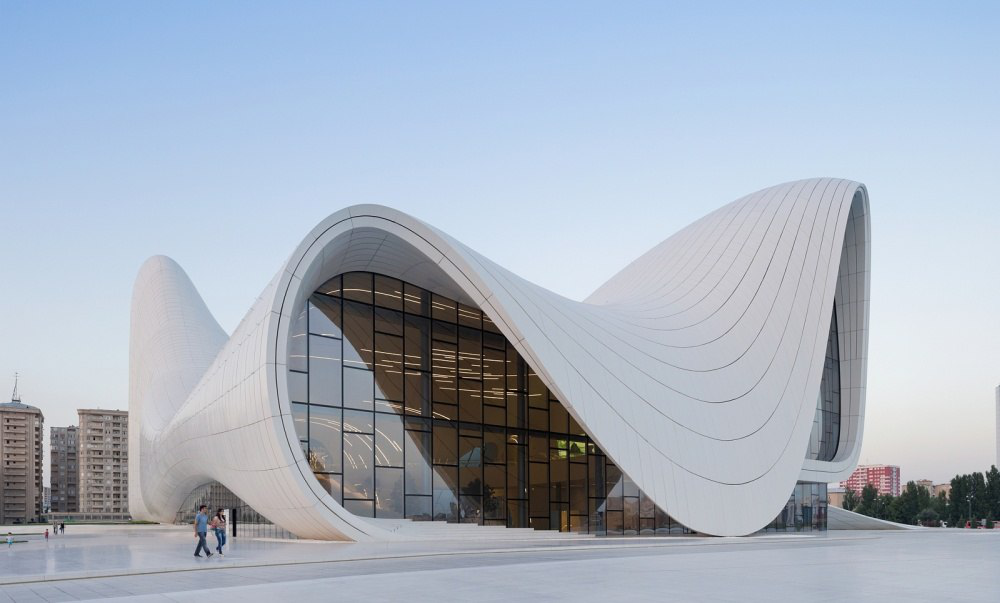

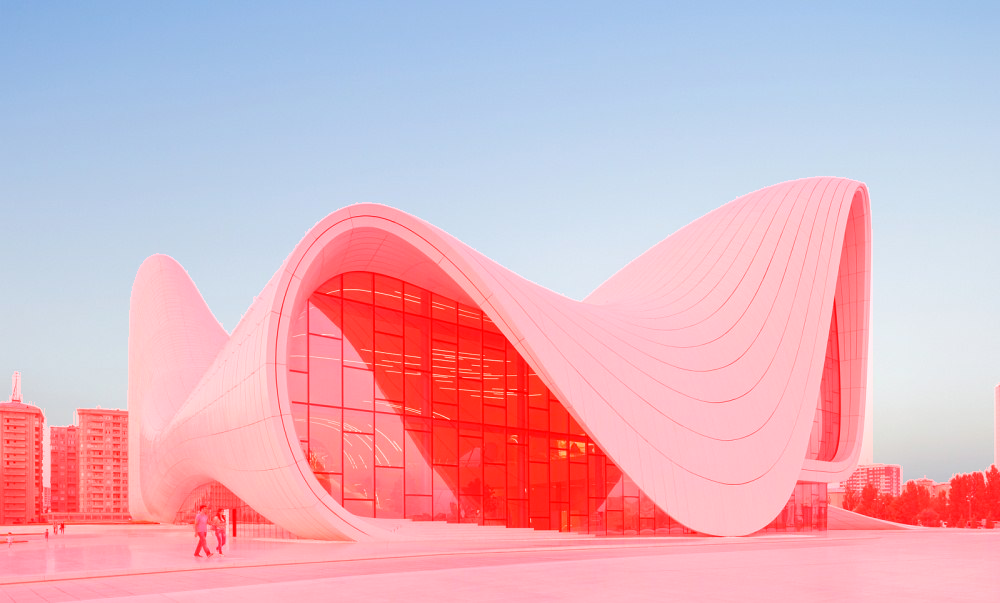

<class 'numpy.ndarray'>


In [12]:
def detect_sky(image):
    display(input_image)

    bopt = calculate_border_optimal(image)

    if no_sky_region(bopt, image.shape[0]/30, image.shape[0]/4, 5):
        display("No sky detected")
        return

    display_mask(bopt, image)
    print(type(bopt))

    if partial_sky_region(bopt, image.shape[1]/3):
        bnew = refine_sky(bopt, image)

        display_mask(bnew, image)


# input_image = cv2.imread("fixtures/full_sky.png")
from PIL import Image
img = Image.open('/content/drive/My Drive/NAASt/Imgs/pasha_style.jpg')
img.save('out.png')
input_image = cv2.imread("./out.png")
# input_image = cv2.imread("fixtures/no_sky.png")

detect_sky(input_image)
